In [1]:
%pylab inline
import numpy as np
from astropy.table import Table
from astropy.io import fits as pf
import pylab as p
import matplotlib.pyplot as plt

# Machine Learning Kit:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Cross-Validation:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

# Time:
from time import clock
#table read
from astropy.io import ascii

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Reads FITS file created for Photo_z:
data =ascii.read("Brownmocks_weighted_from_izt_gold_head.out")
print len(data), data.dtype

69782 [('col1', '<i8'), ('col2', '<f8'), ('col3', '<f8'), ('col4', '<i8'), ('col5', '<f8'), ('col6', '<f8'), ('col7', '<f8'), ('col8', '<f8'), ('col9', '<f8'), ('col10', '<f8'), ('col11', '<f8'), ('col12', '<f8'), ('col13', '<f8'), ('col14', '<f8'), ('col15', '<f8'), ('col16', '<f8')]


In [3]:
u_mag = data['col5']  #U magnitude
g_mag = data['col7']  #G magnitude
r_mag = data['col9']  #R magnitude
i_mag = data['col11'] #I magnitude
z_mag = data['col13'] #Z magnitude
y_mag = data['col15'] #Y magnitude
u_err = data['col6']  #U magnitude err
g_err = data['col8']  #G magnitude err
r_err = data['col10'] #R magnitude err
i_err = data['col12'] #I magnitude err
z_err = data['col14'] #Z magnitude err
y_err = data['col16'] #Y magnitude err

z     = data['col3']  #Redshift


0.001184 4.997716


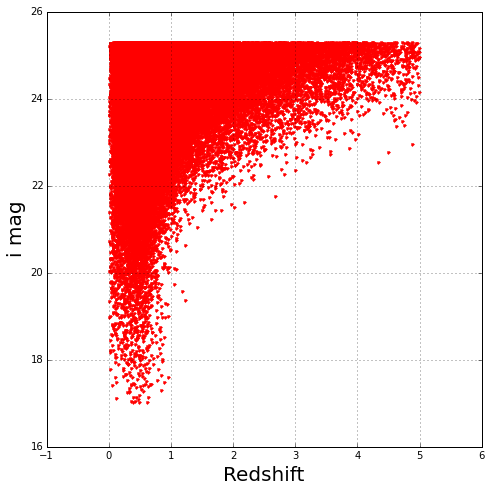

In [5]:
#some consistency checks.
print min(z),max(z)
# Plot of Photometric Redshift vs. i band mag
figure(figsize=(6*1.3, 6*1.3))
plt.plot(z, i_mag, '.', color = 'red')
# Plot Features:
plt.xlim([-1.0, 6])
plt.ylim([16.0, 26])
plt.ylabel('i mag',fontsize=20)
plt.xlabel('Redshift',fontsize=20)
plt.grid(alpha = 0.95)

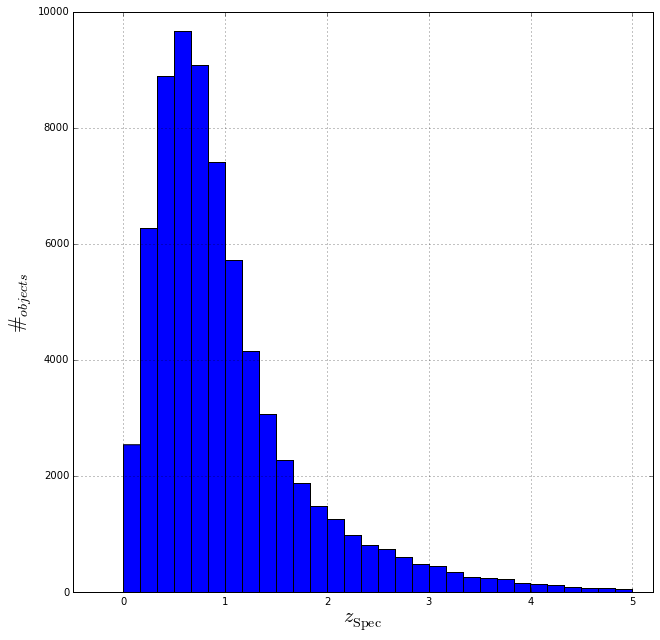

In [8]:
figure(figsize=(8*1.3, 8*1.3))
plt.hist(z,bins=30)

# Axis limits:
plt.ylim([0.0, 10000.0])
plt.xlim([-.50, 5.2])
# Plot Settings:
plt.xlabel('$z_{\mathrm{Spec}}$', fontsize = 20)
plt.ylabel('$\#_{objects}$', fontsize = 20)
plt.grid(alpha = 0.95)
plt.legend(loc = 'best', fontsize = 20, handlelength = 0, numpoints = 1)
#plt.savefig('photo_z_corr_Vs_spec_z.pdf')



In [9]:
nrepeats = int(6)
#redshiftRn = np.repeat(z, nrepeats, axis=0)
redshiftRn = z

# The array XRn stacks the information contained in the magnitude arrays defined above and forms the dependent variables:

# Training by magnitude

#XRn = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((g_mag,r_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,r_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,r_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,r_mag,i_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag))


# Training by color
XRn = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag, i_mag-z_mag, z_mag-y_mag))

#XRn = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, y_mag))
#XRn_pt = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag, i_mag-z_mag, z_mag-(y_mag-0.1)))

print len(redshiftRn), len(XRn)

69782 69782


In [10]:
# To better assess the quality of the Random Forest fitting, we split the data into Training (80%) and Test (20%) sets. 
#The code below performs this task:
XRn_train, XRn_test, redshiftRn_train, redshiftRn_test = train_test_split(XRn, redshiftRn, test_size = 0.20, train_size = 0.80)

# We now use RandomForestRegressor defined as 'regrn'. Notice that here we are using the optimized values for 'n_estimators' and
# 'max_depth':
regrn = RandomForestRegressor(n_estimators = 100, max_depth = 70, max_features = 'auto')
regrn.fit(XRn_train, redshiftRn_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
# We are unable to plot the obtained regression in its entirety due to its multidimensional character. Alternatively, we 
# can assess how good is the obtained regression by checking its score, given by:
print 'Regression Score: ', regrn.score(XRn_test, redshiftRn_test)

#Standard Deviation of the Model against Data:
std_result = np.std((regrn.predict(XRn_test) - redshiftRn_test)/(1 + redshiftRn_test), ddof=1)
print 'Standard Deviation: ', std_result

#Percentage of Model Outliers compared to Data:
outl_result = np.sum(((regrn.predict(XRn_test) - redshiftRn_test)/(1 + redshiftRn_test) > 0.15).astype('int'))*100/float(len(redshiftRn_test))
print 'Percentage of Outliers: ', outl_result, '%'

#Normalized MAD (Median Absolute Deviation):
mad_result = np.median(np.abs((regrn.predict(XRn_test) - (redshiftRn_test))/(1 + redshiftRn_test)))/0.6745
print 'Normalized MAD: ', mad_result

Regression Score:  0.816213383772
Standard Deviation:  0.192825776605
Percentage of Outliers:  6.09729884646 %
Normalized MAD:  0.0338646409984


In [12]:
z_test= redshiftRn_test 

photo_z = regrn.predict(XRn_test)
b = np.sqrt(np.mean((photo_z - z_test)**2/(1+z_test)**2))
print 'RMSD: ', b

#np.savetxt('test_set_sim_z_photo_z_LSST_Brownmocks_weighted.txt', np.c_[z_test,photo_z], header='SIM z, photo_z')

no_outlier_test = (numpy.absolute((photo_z - z_test)/(1+z_test)) < 0.15)

b_no_outlier = np.sqrt(np.mean((photo_z[np.where(no_outlier_test == True)] - z_test[np.where(no_outlier_test == True)])**2/(1+z_test[np.where(no_outlier_test == True)])**2))
print len(photo_z[np.where(no_outlier_test == True)]), len(photo_z[np.where(no_outlier_test == False)])
print 1310.0/(12647+1310.0),b_no_outlier

#print XRn_test.dtype.names

RMSD:  0.194212821143
12564 1393
0.0938597119725 0.0433067916891


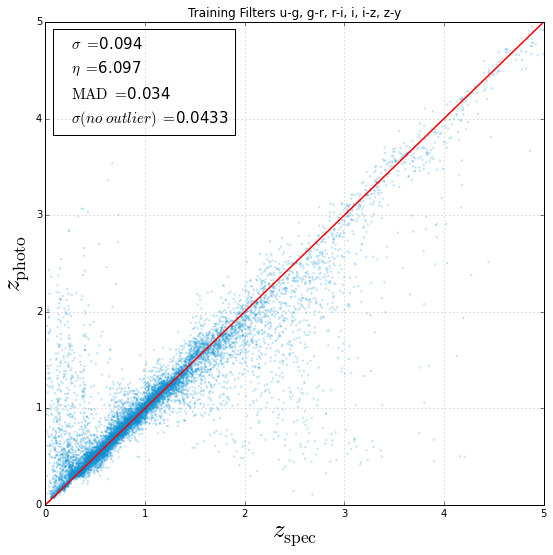

In [13]:
# Plot of Photometric Redshift vs. Spectroscopic Redshift

figure(figsize=(6*1.3, 6*1.3))

plt.plot(np.arange(0,5.4,0.05), np.arange(0,5.4,0.05), linewidth=1.5, color = 'red')
plt.scatter(redshiftRn_test, regrn.predict(XRn_test), facecolors='#088ED1', edgecolors='none', marker = '.', alpha=0.25)

plt.plot(0,0, label = '$\sigma \ = $'+str(round(b-.1,3)), color = 'white')
plt.plot(0,0, label = '$\eta \ = $'  +str(round(outl_result,3)), color = 'white')
plt.plot(0,0, label = '$\mathrm{MAD} \ = $'+str(round(mad_result,3)), color = 'white')
plt.plot(0,0, label = '$\sigma (no\ outlier)\ = $'  +str(round(b_no_outlier,4)), color = 'white')

# Axis limits:
plt.xlim([0.0, 5])
plt.ylim([0.0, 5])
        
# Plot Settings:
plt.title('Training Filters u-g, g-r, r-i, i, i-z, z-y')
plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 25)
plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 25)
plt.grid(alpha = 0.5)
plt.legend(loc = 'best', fontsize = 15, handlelength = 0, numpoints = 1)
plt.tight_layout()
#plt.savefig('A_new_LSST_photo_z_Vs_spec_z_u, u-g, g-r, r-i, i-z, z-y.jpg')


In [14]:
#numpy.savetxt('phot_z_y_0_1.txt', p_z_y_0_1, fmt='%.5e', delimiter=' ', newline='\n', header='del_m_y=-0.1', footer='', comments='# ')

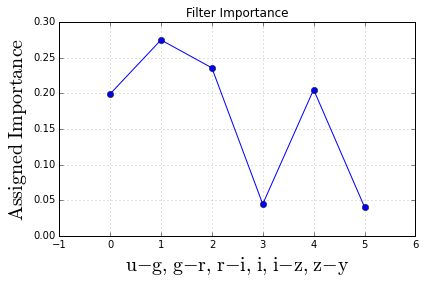

In [15]:
plt.plot(regrn.feature_importances_,marker='o')

# Plot Settings:
plt.title('Filter Importance')
plt.ylabel('$\mathrm{Assigned\ Importance}$', fontsize = 20)
plt.xlabel('$\mathrm{u-g,\ g-r,\ r-i,\ i, \ i-z,\ z-y}$', fontsize = 20)
plt.xlim(-1,6)
plt.ylim(0.0,0.30)
plt.grid(alpha = 0.5)

plt.tight_layout()
#plt.savefig('a_new_LSST_photo_z_importance_u, u-g, g-r, r-i, i-z, z-y.jpg')

In [16]:
print np.sum(regrn.feature_importances_)
print regrn.feature_importances_

1.0
[ 0.19907055  0.27495846  0.23577466  0.04451682  0.20525179  0.04042772]


In [ ]:
#u, colors filter weights - 0.05656474  0.19178656  0.278326    0.22896145  0.20361457  0.04074669
#g, colors filter weights - 0.19989126  0.04423721  0.27638897  0.23156749  0.20768572  0.04022934
#r, colors filter weights - 0.19893372  0.27955807  0.04752367  0.22116137  0.2124323   0.04039086
#i, colors filter weights - 0.20061923  0.28704898  0.22430475  0.04440339  0.20378911  0.03983453
#z, colors filter weights - 0.19854206  0.2835094   0.22344248  0.20961239  0.04417039  0.04072327
#y, colors filter weights - 0.20282818  0.27848327  0.23526641  0.20563608  0.04162917  0.03615689
#u,g,r,i,z filter weights - 0.20360785  0.19694002  0.18753883  0.14434343  0.14371207  0.12385781